In this notebook, we download a PDB structure and load it to this notebook. Then, we simulate AFM process by a dilation from the given tip shape, creating AFM test data for blind tip reconstruction.

# Download a structure and load it to this notebook

In [1]:
using Plots, HTTP, DelimitedFiles, Statistics
using Revise, MDToolbox
ENV["COLUMNS"] = 150; #display width for MDToolbox

In [2]:
download("https://files.rcsb.org/download/1OE9.pdb", "./6BNO.pdb")

"./6BNO.pdb"

In [3]:
#t = mdload("1OE9.pdb")
t = mdload("6BNO.pdb")
t = t["protein and chain A"]
decenter!(t)

1x1 TrjArray{Float64, Int64}
|     2.09     0.46    50.94 |

# Emulation of AFM with dilation

In [4]:
# AFM image and tip shape parameters
width = 15
height = 15
resolution = 15
radius = 25.0
angle = 10.0
param = AfmizeConfig(angle * (pi / 180),
        radius, 
        MDToolbox.Point2D(-height * resolution, -width * resolution), 
        MDToolbox.Point2D(height * resolution, width * resolution), 
        MDToolbox.Point2D(resolution, resolution), 
        MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 25.0, MDToolbox.Point2D{Int64}(-225, -225), MDToolbox.Point2D{Int64}(225, 225), MDToolbox.Point2D{Int64}(15, 15), Dict("SI" => 2.1, "CH1" => 1.7, "CZ3" => 1.7, "C" => 1.7, "CH" => 1.7, "ND2" => 1.55, "NE1" => 1.55, "MG" => 1.73, "P" => 1.8, "GLY" => 2.25…))

(xc, yc) = (5, 5)


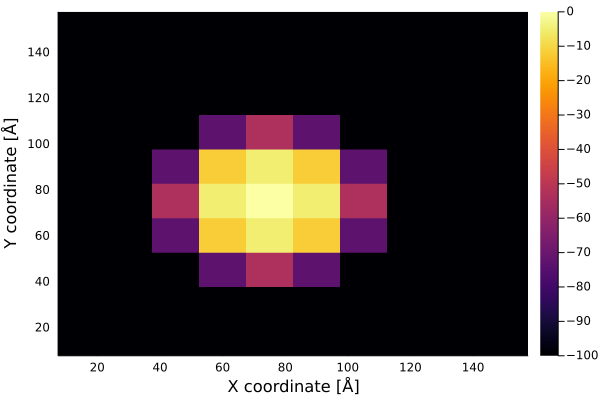

In [5]:
nx = 10
ny = 10
tip = zeros(Float64, ny, nx)
MDToolbox.afmize!(tip, param)
heatmap(collect(1:nx) .* resolution, collect(1:ny) .* resolution, tip, clim=(-100, 0))
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [6]:
tip = MDToolbox.translate_tip_mean(tip)

10×10 Matrix{Float64}:
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -223.495  -138.426   -53.3564    -5.0        0.0       -5.0      -53.3564  -138.426  -223.495  -308.564
 -233.967  -152.23    -73.4385   -11.7712    -5.0      -11.7712   -73.4385  -152.23   -233.967  -316.988
 -263.659  -189.939  -123.83     -73.4385   -53.3564   -73.4385  -123.83    -189.939  -263.659  -341.33
 -308.564  -244.136  -189.939   -152.23    -138.426   -152.23    -189.939   -244.136  -308.564  -379.253
 -364.442  -308.564  -263.659   -233.967   -223.495   -233.967   -263.659   -308.564  -364.442  -427.927
 -427.927  -379.253  -341.33    -3

In [7]:
q = readdlm("../quaternion/QUATERNION_LIST_576_Orient");

In [8]:
using Random

models = t[0, :]
surfs = []
images = []

for i in randperm(MersenneTwister(777), 576)
    t_rotated = MDToolbox.rotate(t, q[i, :])
    surf = MDToolbox.surfing(t_rotated, param)
    image = idilation(surf, tip)
    models = vcat(models, t_rotated)
    push!(surfs, surf)
    push!(images, image)
end    

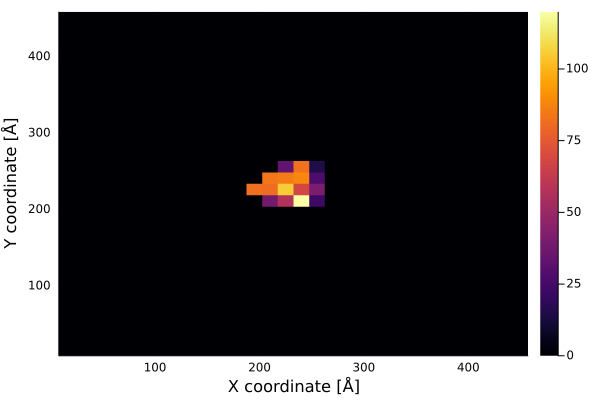

In [9]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

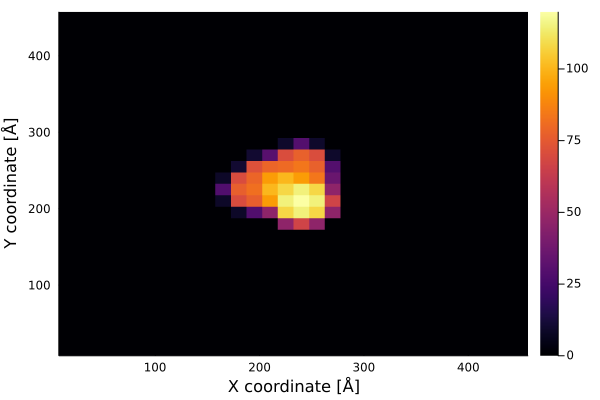

In [10]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [11]:
images_randn = deepcopy(images)

for i in 1:length(images)
    images_randn[i] .= images[i] .+ 3.0 * randn(eltype(images[i]), size(images[i]))
end

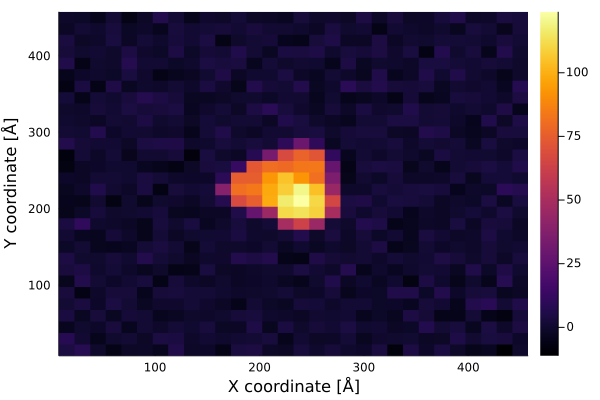

In [12]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images_randn[1])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [13]:
using BSON: @save, @load
@save "prepare_test_data.bson" width height resolution radius angle param models tip nx ny surfs images images_randn

In [14]:
mdsave("models.pdb", models)